In [1]:
import pandas as pd
import warnings
from sklearn.linear_model import Ridge
import statsmodels.regression.linear_model as sm
import statsmodels.tools.tools as t
import seaborn as sns
import matplotlib.pyplot as plt

This part of the analysis will focus on the check the association between countries’ greenhouse gas emissions and their air pollution (target/dependent variable). We will also include data on countries' statuses with the Paris Climate Agreement. The following is further information on each of these variables.

The greenhouse gas emissions include CO2 (fossil only), CH4, N2O and F-gases. They are combined using Global Warming Potential values from IPCC AR5. This data comes from the Emissions Database for Global Atmospheric Research [source](https://edgar.jrc.ec.europa.eu/report_2023#data_download).

Air pollution will be represented through Nitrogen Dioxide levels in the air. This data comes from a World Health Organization database ([source](https://www.who.int/data/gho/data/themes/air-pollution/who-air-quality-database/2022))

The Paris Climate Agreement data assigns each country one of the following values: "R" for Ratification, "A" for Acceptance, "AA" for Approval, "a" for Accession, or "None" for no participation. This data comes from the United Nations Treaty Collection [source](https://treaties.un.org/pages/ViewDetails.aspx?src=TREATY&mtdsg_no=XXVII-7-d&chapter=27&clang=_en).

First, we will read in the data discusssed above from the stored csv files.

In [2]:
## Reading in the data
air_quality_dat = pd.read_csv("fetched_data/AIR_QUALITY_DATA.csv")

paris_agreement_dat = pd.read_csv("fetched_data/PARIS_AGREEMENT_DATA.csv")

greenhouse_gas_dat = pd.read_csv("fetched_data/GHG_DATA.csv")

In order to complete the analysis the datasets will be merged together, and appropriate columns should be selected.

In [3]:
# Merging all the data needed for analysis, 
# making sure no data is lost from our target variable air quality
merged_data = air_quality_dat.merge(paris_agreement_dat, how = "left", on = "Country_Name").merge(greenhouse_gas_dat, how = "left", left_on = ["Country_Name"], right_on = ["Country"])


In [4]:
# Selecting columns needed for analysis
simplified_data = merged_data[["Country_Name", "NO2", "GHG_Emissions", "Date_Joined"]].rename(columns = {"Date_Joined":"Paris_Status"})

One issue we ran into is that some citites are missing NO2 values. One way to address this problem is by filling NULL values will 0. However, this would likely result in an underestimation of a country's NO2 levels. Therefore, we decided to employ median imputation. This may result in a slight overestimation of NO2 values since smaller cities potentially are more difficult to obtain NO2 readings for and therefore may have more NULL values. However, some investigation revealed that there are also medium sized cities with NULL values, therefore median imputation seems like a reasonable approach. There are no missing values for the Greenhouse Gas Emissions measurements.

In [13]:
## Applying median imputation
simplified_data['NO2'] = simplified_data.groupby("Country_Name")['NO2'].transform(lambda x: x.fillna(x.median()))

We also decided to remove countries that have no NO2 measurements from the analysis. We made this decision since data without an air quality value will not be informative for investigating the association between greenhouse gasses and paris agreement countries, and air quality.

In [6]:
# Group by 'Country' column
simplified_data_grouped = simplified_data.groupby('Country_Name')

# Drop rows where all NO2 values are null within each country group
simplified_data_minimal = simplified_data_grouped.filter(lambda x: x['NO2'].notna().any())

We are conducting this analysis at the country level. Therefore, we will sum up NO2 values for each country. One limitation to keep in mind is that there may be some cities missing from the dataset, which would result in an underestimate of a country's NO2 values.

In [7]:
aggregated_data = simplified_data_minimal.groupby(['Country_Name',"GHG_Emissions","Paris_Status"]).sum().reset_index()

Next, we will one-hot-encode our paris agreement variable for ease of analysis. We will create a new column for each of the categories: 'A', 'AA', 'R', and 'None'. The 'a' category will not be included since none of the countries with NO2 levels have an 'a' paris agreement status. 

In [20]:
one_hot_encoded_data = pd.get_dummies(aggregated_data, columns = ['Paris_Status']) 
one_hot_encoded_data[['Paris_Status_A         ',
       'Paris_Status_AA        ', 'Paris_Status_None      ',
       'Paris_Status_R         ']] = one_hot_encoded_data[['Paris_Status_A         ',
       'Paris_Status_AA        ', 'Paris_Status_None      ',
       'Paris_Status_R         ']].astype(int)

Now, we will split our data into X (independent variables) and y (dependent/target variable). We add a constant to act as an intercept for the linear regression fit.

In [9]:
X = one_hot_encoded_data.drop(columns = ["NO2","Country_Name"])
X = t.add_constant(X)
y = one_hot_encoded_data[["NO2"]]

Now we will use linear regression and least-squares-estimation to fit a linear model to our data.

In [10]:
result = sm.OLS(y, X).fit()
 
# printing the summary table
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    NO2   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                 -0.054
Method:                 Least Squares   F-statistic:                    0.3296
Date:                Mon, 18 Mar 2024   Prob (F-statistic):              0.857
Time:                        12:49:51   Log-Likelihood:                -465.70
No. Observations:                  53   AIC:                             941.4
Df Residuals:                      48   BIC:                             951.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

The Adjusted R-Squared value from this linear fit is -0.054. This indicates that the linear model is not a good fit for the data we have. In addition the p-values for the co-efficients are all fairly high (above 0.17). This indicates that the fitted coefficients do not seem to be statistically significant from zero.

Overall, there does not seem to be a significant association between air quality (NO2) and Greenhouse Gas Emissions. Nor does there seem to be a difference in intercept for any status of the paris agreement.

The following plot of the data with the fitted linear model may help us gain some insight.

Text(49.542774305555554, 0.5, 'NO2 Air Levels')

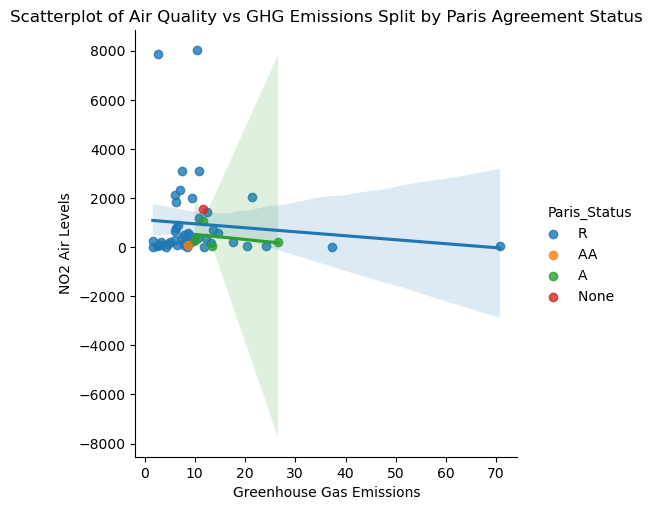

In [21]:
sns.lmplot(x='GHG_Emissions', y='NO2', hue="Paris_Status", data=aggregated_data)
ax = plt.gca()
ax.set_title("Scatterplot of Air Quality vs GHG Emissions Split by Paris Agreement Status")
ax.set_xlabel("Greenhouse Gas Emissions")
ax.set_ylabel("NO2 Air Levels")

The data points are fairly clumped near 0 NO2 levels, and then spread out across Greenhouse Gas Emission levels. There are a few outliers either with large GHG emission values and small NO2 levels or vice versa. As we saw in our model, and now here, there is no clear association beteween Air Quality (NO2) and Greenhouse Gas emissions. It is also difficult to draw any insight from the paris agreement status as most countries included have a status of 'R' with only a handful having a different status.

Overall, there is no evidence of association between air quality, represented by NO2, and Greenhouse Gas Emissions, split across Paris Agreement status.